# Laboratorio 5: Redes Neuronales Recurrentes (RNN) para Series de Tiempo

## Autores:

- Nelson García 22434
- Christian Echeverría 221



## Carga y exploración de datos:



Importar las librerías:

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected = True)  # para que funcione bien con Jupyter Notebook
import plotly.graph_objs as go
import plotly.express as px
from IPython.display import HTML  # Esto es para ver las gráficas de Plotly en el Colab

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-09-01 19:31:52.737191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Cargamos los datos

In [2]:
df = pd.read_csv('./Datos/IPN31152N.csv')
df.head()

,observation_date,IPN31152N
0,1972-01-01,60.1519
1,1972-02-01,67.2727
2,1972-03-01,74.4700
3,1972-04-01,78.3594
4,1972-05-01,85.0321


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  642 non-null    object 
 1   IPN31152N         642 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.2+ KB


Se convierte la fecha de Object a DateTime

In [4]:
df = pd.read_csv('./Datos/IPN31152N.csv',
                 index_col = 'observation_date',
                 parse_dates = True)


In [5]:
df.head(20)


,IPN31152N
observation_date,
1972-01-01,60.1519
1972-02-01,67.2727
1972-03-01,74.4700
1972-04-01,78.3594
1972-05-01,85.0321
1972-06-01,100.9147
1972-07-01,100.4435
1972-08-01,96.6660
1972-09-01,86.0726


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 642 entries, 1972-01-01 to 2025-06-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  642 non-null    float64
dtypes: float64(1)
memory usage: 10.0 KB


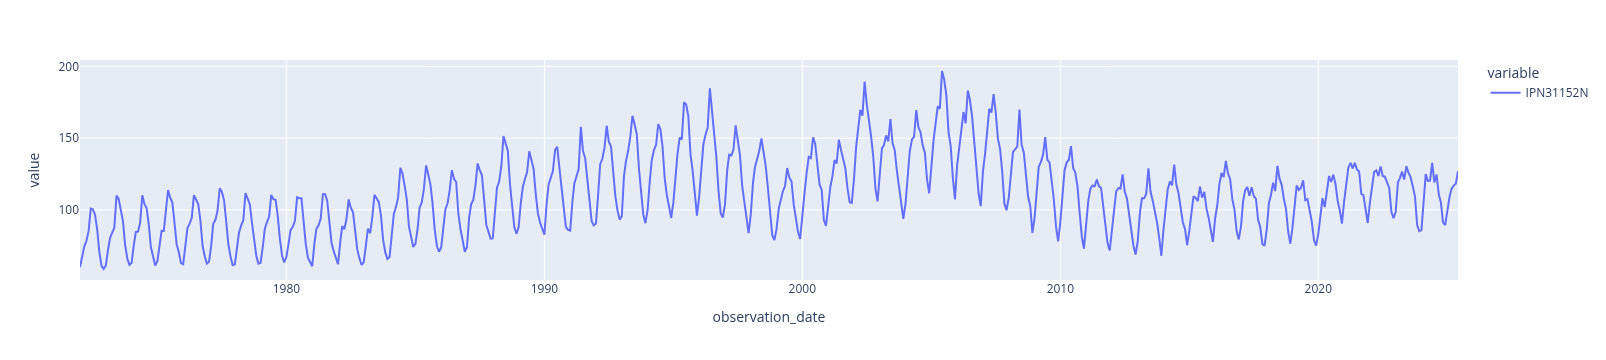

In [7]:
fig = px.line(df)
fig.show()

## División de conjuntos

In [8]:
len(df)

642

Vamos a tomar los últimos 24 meses para nuestro set de tests.

In [9]:
tamanio_prueba = 24

In [10]:
indice_prueba = len(df) - tamanio_prueba

In [11]:
entreno = df.iloc[: indice_prueba]
prueba = df.iloc[indice_prueba:]

In [12]:
entreno

,IPN31152N
observation_date,
1972-01-01,60.1519
1972-02-01,67.2727
1972-03-01,74.4700
1972-04-01,78.3594
1972-05-01,85.0321
...,...
2023-02-01,119.2751
2023-03-01,122.0175
2023-04-01,126.6790


In [13]:
prueba

,IPN31152N
observation_date,
2023-07-01,126.0569
2023-08-01,122.6748
2023-09-01,116.2177
2023-10-01,109.3279
2023-11-01,89.3353
2023-12-01,85.2839
2024-01-01,85.9573
2024-02-01,110.0548
2024-03-01,124.9787


## Normalización y preparación

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(entreno)

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [16]:
datos_entreno_escalados = scaler.transform(entreno)
datos_prueba_escalados = scaler.transform(prueba)

## Generador de series de tiempo

In [17]:
longitud = 12
tamanio_tanda = 32
generador = TimeseriesGenerator(datos_entreno_escalados,
                                datos_entreno_escalados,
                                length = longitud,
                                batch_size = tamanio_tanda)

In [18]:
X,y = generador[0]

In [19]:
print(f'Dado el arreglo: \n{X.flatten()}')
print(f'Predecir esta y: \n {y}')

Dado el arreglo: 
[0.00946788 0.06107842 0.11324343 0.14143325 0.18979603 0.30491086
 0.30149567 0.27411688 0.19733743 0.08531309 0.01561334 0.
 0.06107842 0.11324343 0.14143325 0.18979603 0.30491086 0.30149567
 0.27411688 0.19733743 0.08531309 0.01561334 0.         0.01773913
 0.11324343 0.14143325 0.18979603 0.30491086 0.30149567 0.27411688
 0.19733743 0.08531309 0.01561334 0.         0.01773913 0.09849259
 0.14143325 0.18979603 0.30491086 0.30149567 0.27411688 0.19733743
 0.08531309 0.01561334 0.         0.01773913 0.09849259 0.15587533
 0.18979603 0.30491086 0.30149567 0.27411688 0.19733743 0.08531309
 0.01561334 0.         0.01773913 0.09849259 0.15587533 0.18355852
 0.30491086 0.30149567 0.27411688 0.19733743 0.08531309 0.01561334
 0.         0.01773913 0.09849259 0.15587533 0.18355852 0.20875425
 0.30149567 0.27411688 0.19733743 0.08531309 0.01561334 0.
 0.01773913 0.09849259 0.15587533 0.18355852 0.20875425 0.37144257
 0.27411688 0.19733743 0.08531309 0.01561334 0.         0.01

## Construcción del modelo

Tenemos 1 feature.

In [20]:
n_features = 1

In [21]:
modelo = Sequential()
modelo.add(LSTM(100, activation = 'relu', input_shape = (longitud,
                                                         n_features)))
modelo.add(Dense(1))
modelo.compile(optimizer = 'adam', loss = 'mse')

I0000 00:00:1756776718.203307   72081 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1728 MB memory:  -> device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:02:00.0, compute capability: 6.1
/home/nelson/Documents/Uvg/Data Science/Lab5_DataScience/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [22]:
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento:

In [23]:
detencion_temprana = EarlyStopping(monitor = 'val_loss', patience = 2)

In [24]:
generador_validacion = TimeseriesGenerator(datos_prueba_escalados,
                                           datos_prueba_escalados,
                                           length = longitud,
                                           batch_size = tamanio_tanda)

In [25]:
modelo.fit(generador, epochs = 20,
                    validation_data = generador_validacion,
                    callbacks = [detencion_temprana])

Epoch 1/20


/home/nelson/Documents/Uvg/Data Science/Lab5_DataScience/venv/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

2025-09-01 19:32:02.595169: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fb510003890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-01 19:32:02.595187: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
2025-09-01 19:32:02.633977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-01 19:32:02.810102: I external/local_xla/xla/stream_executor/cuda/cuda_dnn

 1/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.1465

I0000 00:00:1756776723.605932   72156 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.1071 - val_loss: 0.0173
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0297 - val_loss: 0.0074
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239 - val_loss: 0.0079
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - val_loss: 0.0067
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0201 - val_loss: 0.0069
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - val_loss: 0.0057
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132 - val_loss: 0.0062
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 - val_loss: 0.0033
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - val_loss: 0.0016
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0037
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - val_loss: 0.0016
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0069

In [26]:
perdidas = pd.DataFrame(modelo.history.history)

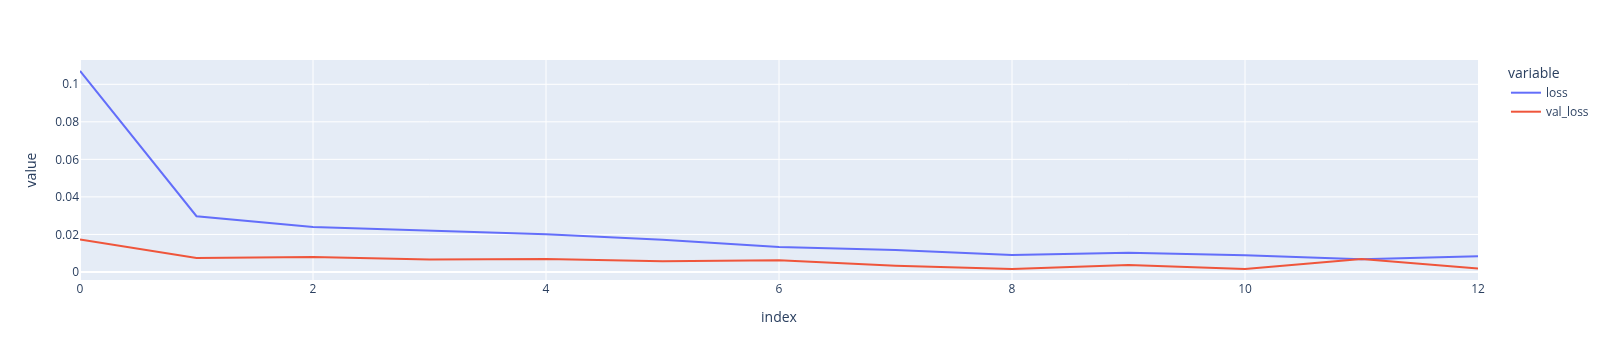

In [27]:
fig = px.line(perdidas)
fig.show()

## Evaluación

In [28]:
primera_tanda_eval = datos_entreno_escalados[-longitud:]

In [29]:
primera_tanda_eval = primera_tanda_eval.reshape((1, longitud, n_features))

In [30]:
modelo.predict(primera_tanda_eval)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


array([[0.43021914]], dtype=float32)

In [31]:
datos_prueba_escalados[0]

array([0.48713795])

In [32]:
predicciones_prueba = []

primera_tanda_eval = datos_entreno_escalados[-longitud:]
tanda_actual = primera_tanda_eval.reshape((1, longitud, n_features))

for i in range(len(prueba)):
    prediccion_actual = modelo.predict(tanda_actual)[0]

    predicciones_prueba.append(prediccion_actual)

    tanda_actual = np.append(tanda_actual[:,1:,:],
                             [[prediccion_actual]], axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [33]:
predicciones_reales = scaler.inverse_transform(predicciones_prueba)

In [34]:
prueba['Predicciones'] = predicciones_reales

/tmp/ipykernel_72081/1226055985.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
prueba

,IPN31152N,Predicciones
observation_date,,
2023-07-01,126.0569,118.203710
2023-08-01,122.6748,114.384065
2023-09-01,116.2177,108.591413
2023-10-01,109.3279,101.474756
2023-11-01,89.3353,98.216794
2023-12-01,85.2839,99.251672
2024-01-01,85.9573,102.510571
2024-02-01,110.0548,106.622456
2024-03-01,124.9787,109.643787


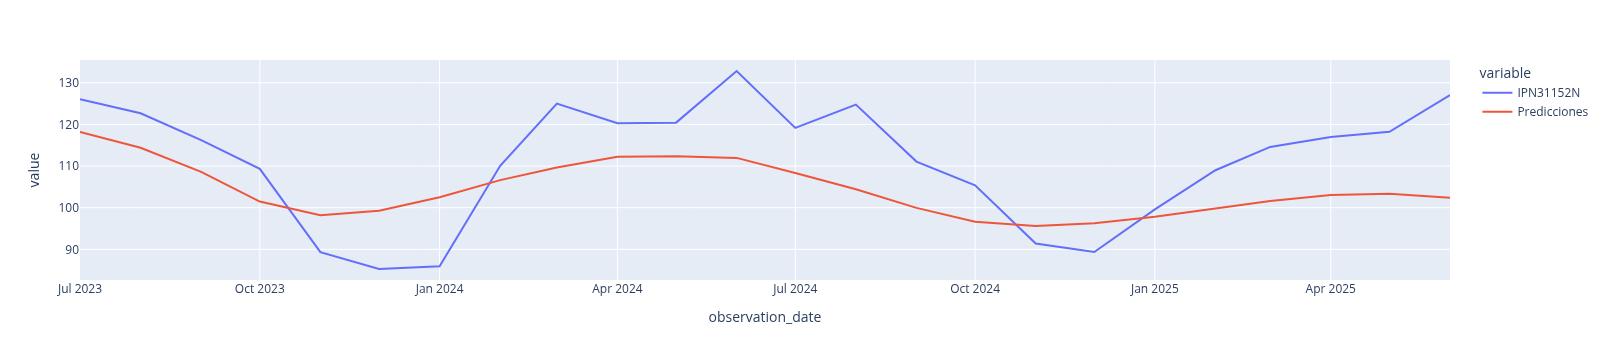

In [36]:
fig = px.line(prueba)
fig.show()

## Entrenar de nuevo

In [37]:
modelo2 = Sequential([
    Input(shape=(longitud, n_features)),
    LSTM(128, activation = 'relu', return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation = 'relu'),
    Dense(1)
])

modelo2.compile(optimizer=Adam(1e-3), loss='mse')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

modelo2.fit(
    generador,
    validation_data=generador_validacion,
    epochs=100,
    callbacks=[es],
    verbose=0
)

In [38]:
perdidas = pd.DataFrame(modelo2.history.history)

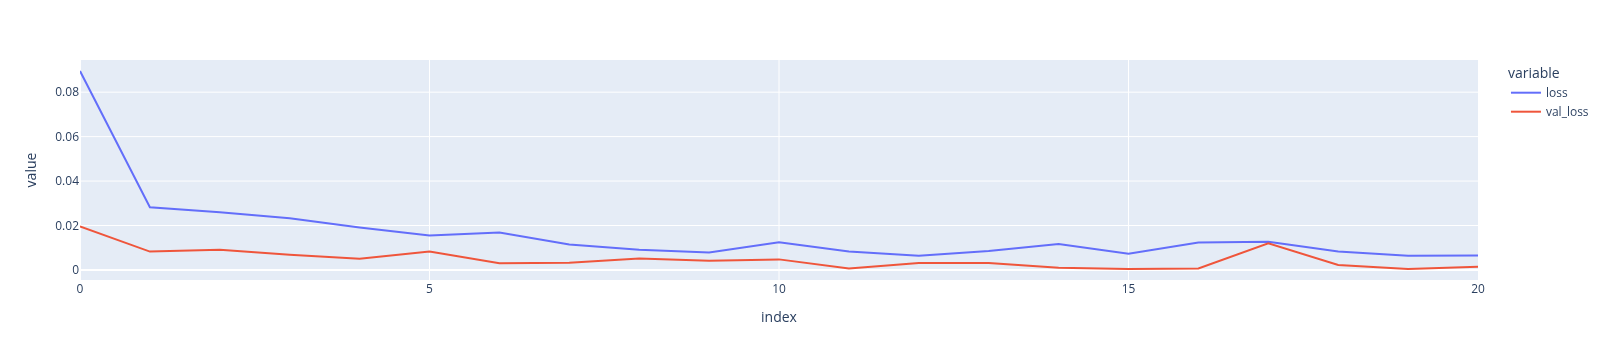

In [39]:
fig = px.line(perdidas)
fig.show()

### Evaluación del nuevo modelo

In [40]:
primera_tanda_eval = datos_entreno_escalados[-longitud:]

In [41]:
primera_tanda_eval = primera_tanda_eval.reshape((1, longitud, n_features))

In [42]:
modelo2.predict(primera_tanda_eval)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


array([[0.44583884]], dtype=float32)

In [43]:
datos_prueba_escalados[0]

array([0.48713795])

In [44]:
predicciones_prueba = []

primera_tanda_eval = datos_entreno_escalados[-longitud:]
tanda_actual = primera_tanda_eval.reshape((1, longitud, n_features))

for i in range(len(prueba)):
    prediccion_actual = modelo2.predict(tanda_actual)[0]

    predicciones_prueba.append(prediccion_actual)

    tanda_actual = np.append(tanda_actual[:,1:,:],
                             [[prediccion_actual]], axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [45]:
predicciones_reales = scaler.inverse_transform(predicciones_prueba)

In [46]:
prueba['Predicciones'] = predicciones_reales

/tmp/ipykernel_72081/1226055985.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
prueba

,IPN31152N,Predicciones
observation_date,,
2023-07-01,126.0569,120.358787
2023-08-01,122.6748,118.668040
2023-09-01,116.2177,115.455419
2023-10-01,109.3279,107.694065
2023-11-01,89.3353,95.978344
2023-12-01,85.2839,97.918411
2024-01-01,85.9573,105.782995
2024-02-01,110.0548,114.392646
2024-03-01,124.9787,117.281826


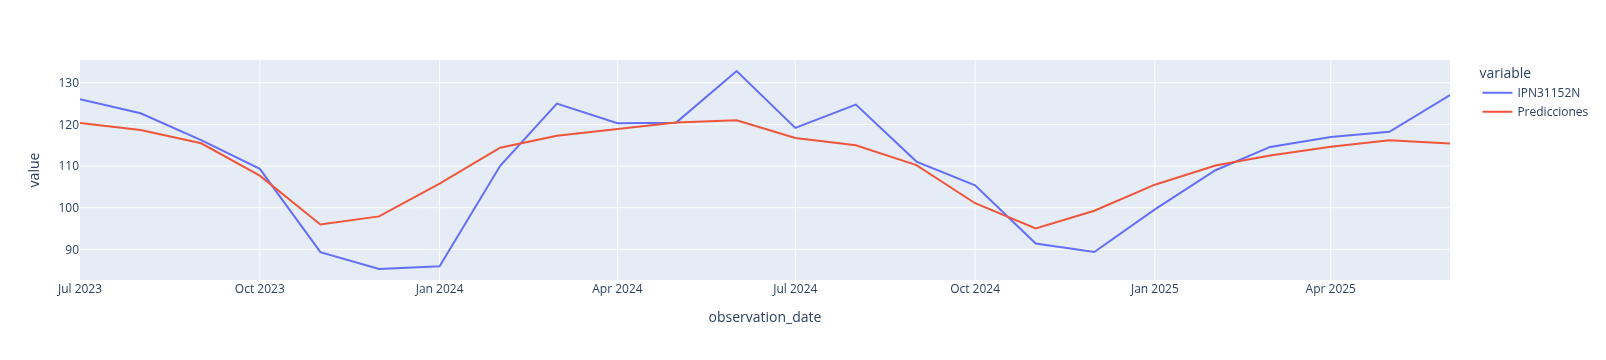

In [48]:
fig = px.line(prueba)
fig.show()

#### PRONÓSTICO ROLLING SOBRE EL CONJUNTO DE PRUEBA


In [49]:
yhat_test_scaled = []
tanda = datos_entreno_escalados[-longitud:].copy()  # última ventana del set de entrenamiento

for _ in range(len(prueba)):
    x = tanda.reshape(1, longitud, n_features)
    yhat = modelo.predict(x, verbose=0)           # predice el siguiente paso (en escala MinMax)
    yhat_test_scaled.append(yhat[0])
    tanda = np.vstack([tanda[1:], yhat])          # avanzamos la ventana con la predicción

pronostico_test = scaler.inverse_transform(np.array(yhat_test_scaled))
prueba = prueba.copy()
prueba['Pronostico'] = pronostico_test


## PRONÓSTICO HACIA EL FUTURO (p pasos)

In [50]:
p = 48  # <- meses futuro a predecir

# Escalamos TODO el histórico con el MISMO scaler (entrenado con 'entreno')
serie_escalada = scaler.transform(df.values)

tanda = serie_escalada[-longitud:]               # última ventana del histórico completo
tanda = tanda.reshape(1, longitud, n_features)

yhat_fut_scaled = []
for _ in range(p):
    yhat = modelo.predict(tanda, verbose=0)
    yhat_fut_scaled.append(yhat[0])
    tanda = np.append(tanda[:, 1:, :], yhat.reshape(1, 1, 1), axis=1)

yhat_fut = scaler.inverse_transform(np.array(yhat_fut_scaled))

# Índice correcto: mes siguiente al último dato real
inicio = df.index[-1] + pd.offsets.MonthBegin(1)
idx_fut = pd.date_range(start=inicio, periods=p, freq='MS')

df_pronostico = pd.DataFrame(yhat_fut, index=idx_fut, columns=['Pronostico'])


/home/nelson/Documents/Uvg/Data Science/Lab5_DataScience/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



#### GRÁFICOS (real + pronóstico en prueba + pronóstico futuro)

/tmp/ipykernel_72081/2257942262.py:2: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.

/tmp/ipykernel_72081/2257942262.py:4: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.



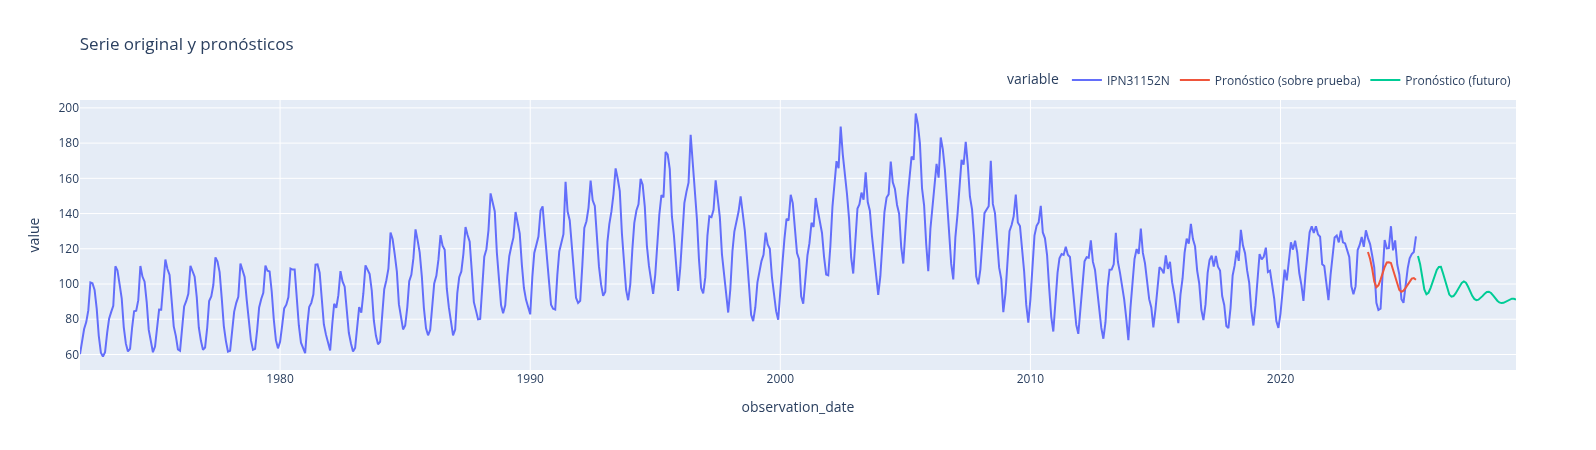

In [51]:
fig = px.line(df, title="Serie original y pronósticos")
fig.add_scatter(x=prueba.index, y=prueba['Pronostico'].ravel(),
                name='Pronóstico (sobre prueba)')
fig.add_scatter(x=df_pronostico.index, y=df_pronostico['Pronostico'].ravel(),
                name='Pronóstico (futuro)')

fig.update_layout(
    width=850, height=450,
    xaxis_range=[df.index.min(), df_pronostico.index.max()],
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
)
fig.show()


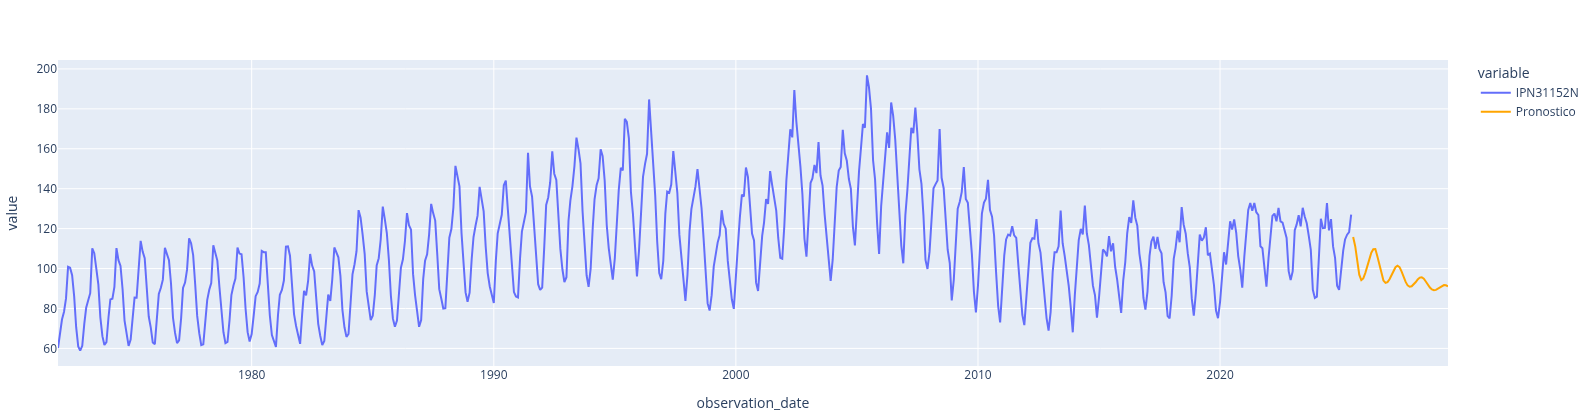

In [52]:
# para df histórico
df = df.copy()
df.index = pd.to_datetime(df.index)     # por si viene como string
df = df.sort_index()
df.index.name = "observation_date"      # solo el nombre del eje

# para df_pronostico (la serie de pronóstico)
df_pronostico = df_pronostico.copy()
df_pronostico.index = pd.to_datetime(df_pronostico.index)
df_pronostico = df_pronostico.sort_index()
df_pronostico.index.name = "observation_date"

import plotly.express as px

# px.line en modo "wide": usa el índice como eje X automáticamente
fig = px.line(df)                       # histórico
fig2 = px.line(df_pronostico)           # pronóstico

# Forzar color naranja al pronóstico
for tr in fig2.data:
    tr.update(line=dict(color="orange"))

# Añadir la(s) traza(s) del pronóstico al gráfico base
fig.add_traces(list(fig2.data))

# Rango de X: del inicio histórico al final del pronóstico
xmin = df.index.min()
xmax = max(df.index.max(), df_pronostico.index.max())

fig.update_layout(
    width=800, height=420,
    xaxis_title="observation_date", yaxis_title="value",
    xaxis_range=[xmin, xmax],
    legend_title_text="variable",
    margin=dict(l=40, r=20, t=60, b=40)
)

fig.show()

### Analisis y discusión

Como podemos ver los scalers son muy importantes con las RNN, porque gracias a haber escalado los datos bien las predicciones de futuro si bien se logran captar de manera acertada, no picos y cambios abruptos no se logran de la manera correcta por el hecho de que subestima medias y prefiere hacer estimaciones más "suaves".

Conclusión
El early stoping que utilizamos si que nos ayudo a mejorar tanto el tiempo como predicciones ya que si no se aplicaba de manera correcta nos podía dar un sobre ajuste asi como también hacer un early demasiado temprano nos quita precisión en predicciones. El uso de scaler fue crucial para ajustar los datos y acercarnos a las predicciones generales, más no logra captar la volatibilidad de toda serie de tiempo ya que esto tambien necesita de un training mucho más exaustivo y obviamente que las predicciones no pueden captar totalmente la naturaleza de los datos reales